In [ ]:
from google.colab import drive
import os
import tarfile

try:
    drive.flush_and_unmount()
    print('Drive unmounted.')
except Exception as e:
    pass

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

dataset_tar_path = '/content/drive/MyDrive/DLPMid02/VOCtrainval_14-Jul-2008.tar'
extract_path = '/content/'

if not os.path.exists(os.path.join(extract_path, 'VOCdevkit')):
    print("Extracting dataset...")
    with tarfile.open(dataset_tar_path, 'r') as tar:
        tar.extractall(path=extract_path)
    print("Extraction complete.")
else:
    print("Dataset already extracted.")

Drive unmounted.
Mounted at /content/drive
Dataset already extracted.


In [ ]:
import os
import xml.etree.ElementTree as ET
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, multilabel_confusion_matrix, average_precision_score

In [ ]:
data_root = 'VOCdevkit/VOC2008'
train_set = 'trainval'
test_set = 'val'

# Dataset definition
class VOCClassificationDataset(Dataset):
    def __init__(self, root_dir, image_set='trainval', transform=None):
        self.root_dir = root_dir
        self.image_set = image_set
        self.transform = transform
        self.image_dir = os.path.join(root_dir, 'JPEGImages')
        self.ann_dir = os.path.join(root_dir, 'Annotations')
        set_file = os.path.join(root_dir, 'ImageSets', 'Main', f'{image_set}.txt')
        with open(set_file) as f:
            ids = [line.strip() for line in f]
        self.classes = [
            'aeroplane','bicycle','bird','boat','bottle','bus','car','cat',
            'chair','cow','diningtable','dog','horse','motorbike','person',
            'pottedplant','sheep','sofa','train','tvmonitor'
        ]
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}
        self.prefix = os.path.basename(root_dir)
        # Filter out ids without valid images
        self.ids = []
        for img_id in ids:
            fname1 = f'{img_id}.jpg'
            fname2 = f'{self.prefix}_{img_id}.jpg'
            path1 = os.path.join(self.image_dir, fname1)
            path2 = os.path.join(self.image_dir, fname2)
            if os.path.exists(path1) or os.path.exists(path2):
                self.ids.append(img_id)
            else:
                print(f"Warning: Image for ID {img_id} not found, skipping.")

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        # Determine which filename exists
        fname1 = f'{img_id}.jpg'
        img_path = os.path.join(self.image_dir, fname1)
        if not os.path.exists(img_path):
            fname2 = f'{self.prefix}_{img_id}.jpg'
            img_path = os.path.join(self.image_dir, fname2)
        image = Image.open(img_path).convert('RGB')
        # Create multi-label target
        label = np.zeros(len(self.classes), dtype=np.float32)
        ann_path = os.path.join(self.ann_dir, f'{img_id}.xml')
        tree = ET.parse(ann_path)
        root = tree.getroot()
        for obj in root.findall('object'):
            cls = obj.find('name').text
            label[self.class_to_idx[cls]] = 1.0
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
# Transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

# Datasets and loaders
train_dataset = VOCClassificationDataset(data_root, image_set=train_set, transform=train_transform)
test_dataset = VOCClassificationDataset(data_root, image_set=test_set, transform=val_transform)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# Pretrained ResNet50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torchvision.models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(train_dataset.classes))
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Hyperparameters
num_epochs = 10
learning_rate = 1e-4

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

Epoch 1/10, Loss: 0.1463
Epoch 2/10, Loss: 0.0847
Epoch 3/10, Loss: 0.0617
Epoch 4/10, Loss: 0.0488
Epoch 5/10, Loss: 0.0385
Epoch 6/10, Loss: 0.0300
Epoch 7/10, Loss: 0.0241
Epoch 8/10, Loss: 0.0212
Epoch 9/10, Loss: 0.0181
Epoch 10/10, Loss: 0.0155


In [ ]:
model.eval()
all_labels = []
all_preds = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.sigmoid(outputs).cpu().numpy()
        all_preds.append(preds)
        all_labels.append(labels.numpy())
all_preds = np.vstack(all_preds)
all_labels = np.vstack(all_labels)

# Binarize predictions
threshold = 0.5
binary_preds = (all_preds >= threshold).astype(int)

# Metrics
accuracy = accuracy_score(all_labels.flatten(), binary_preds.flatten())
precision = precision_score(all_labels, binary_preds, average='samples')
recall = recall_score(all_labels, binary_preds, average='samples')
f1 = f1_score(all_labels, binary_preds, average='samples')
conf_matrices = multilabel_confusion_matrix(all_labels, binary_preds)

# mAP
ap_per_class = [
    average_precision_score(all_labels[:,i], all_preds[:,i])
    for i in range(len(train_dataset.classes))
]
mAP = np.mean(ap_per_class)

# IoU per class
iou_per_class = []
for i in range(len(train_dataset.classes)):
    tp = np.logical_and(all_labels[:,i]==1, binary_preds[:,i]==1).sum()
    fp = np.logical_and(all_labels[:,i]==0, binary_preds[:,i]==1).sum()
    fn = np.logical_and(all_labels[:,i]==1, binary_preds[:,i]==0).sum()
    iou = tp / (tp + fp + fn + 1e-6)
    iou_per_class.append(iou)
mean_IoU = np.mean(iou_per_class)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')
print(f'mAP: {mAP:.4f}')
print(f'Mean IoU: {mean_IoU:.4f}')

Accuracy: 0.9977
Precision: 0.9851
Recall: 0.9921
F1-score: 0.9859
mAP: 0.9986
Mean IoU: 0.9663


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


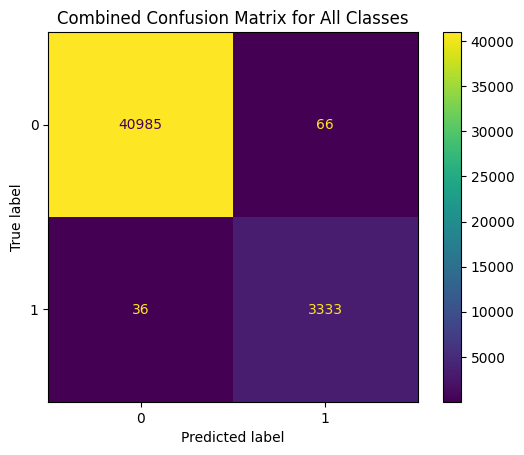

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay

combined_conf_matrix = np.sum(conf_matrices, axis=0)

disp = ConfusionMatrixDisplay(confusion_matrix=combined_conf_matrix, display_labels=[0, 1])

disp.plot()
plt.title('Combined Confusion Matrix for All Classes')
plt.show()

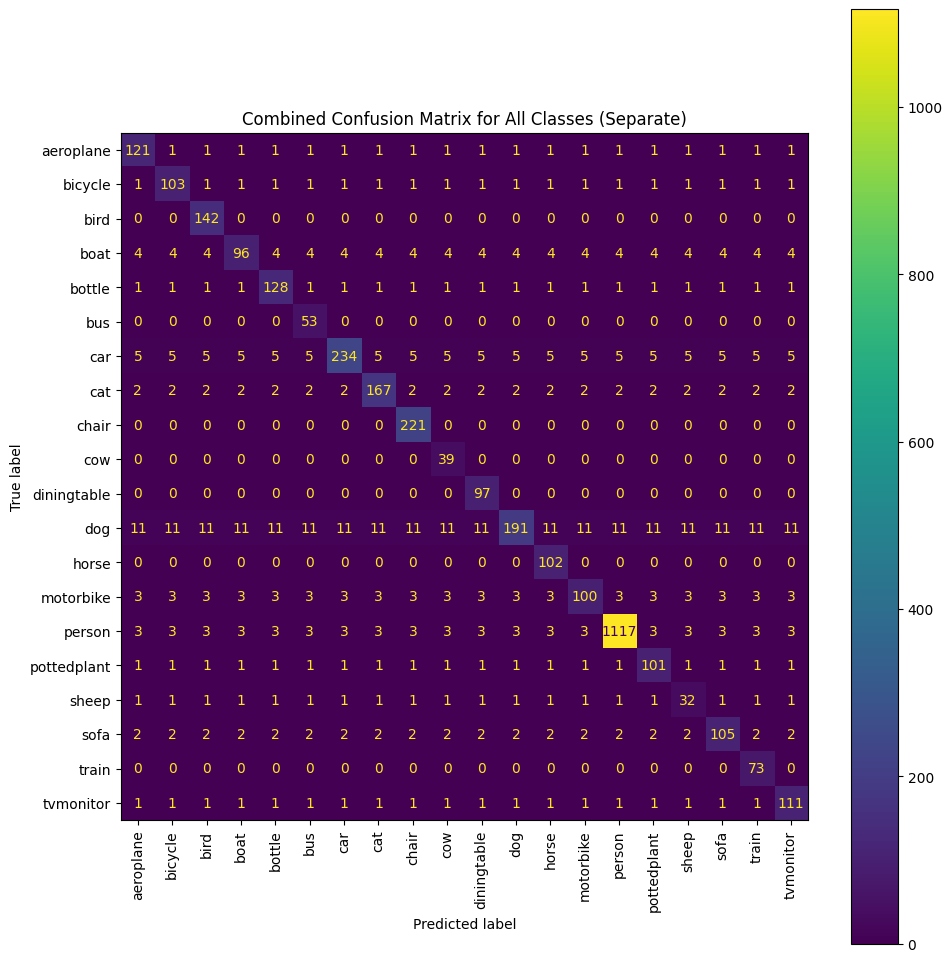

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay

num_classes = len(train_dataset.classes)
combined_conf_matrix = np.zeros((num_classes, num_classes), dtype=int)

# Aggregate confusion data from individual matrices
for i in range(num_classes):
    combined_conf_matrix[i, i] = conf_matrices[i][1, 1]
    for j in range(num_classes):
        if i != j:
            combined_conf_matrix[i, j] = conf_matrices[i][1, 0]


disp = ConfusionMatrixDisplay(confusion_matrix=combined_conf_matrix, display_labels=train_dataset.classes)

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax)
plt.xticks(rotation=90)
plt.title('Combined Confusion Matrix for All Classes (Separate)')
plt.tight_layout()
plt.show()